# Project Benson

## Aim

- High Gala Participation Rate

## How

- Identifying High Traffic Volumes at Subway Entrances/Exits
 - By Day of Week
 - By Hour of Day



- Identifying Target Audience (those more likely to be interested)
 - Identifying Stations with High Volumes of Non-Tourist Traffic (locals)
     - By comparing station's weekend vs weekday traffic

 - [Demographic & Geographic Profiles](https://datausa.io/profile/geo/new-york-ny)
     - Assume areas with more females more interested?
     - Assume areas with higher income more likely to donate?
     - Assume areas with younger demographics more interested?
     - Assume areas with higher education level more interested?
     - Assume areas with high employment in tech industry more interested?
  

## Importing Data for January - June 2019

In [1]:
import pandas as pd
from datetime import datetime

In [2]:
# 2017 Turnstile data from "https://data.ny.gov/Transportation/Turnstile-Usage-Data-2017/v5y5-mwpb"
# Replace the path below with your own
path = "/Users/kc/OneDrive/Projects/projectbenson/data/data_2017.csv"

df = pd.read_csv(path, sep=',')

/Users/kc/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Remove whitespace from column names
df.columns = df.columns.str.strip()

# Drop irrelevant columns
df.drop(columns=["Line Name", "Division", "Description"], axis=1, inplace=True)

In [4]:
# Concatenate Date & Time into DateTime column DT
df["DT"] = df[['Date', 'Time']].apply(lambda x: ' '.join(x), axis=1)

# Convert DT into DateTime format
df["DT"] = pd.to_datetime(df["DT"], infer_datetime_format=True)

# Concatenate C/A, Unit & SCP into 1 Unique Identifier Column
df["ID"] = df[["C/A", "Unit", "SCP"]].apply(lambda x: ' '.join(x), axis=1)

In [5]:
# Rearrange Columns
df = df[["ID", "DT", "Station", "Entries", "Exits"]]

# Drop rows before and after 2017
#df = df.loc[df["DT"].dt.year == 2017]
#df = df.loc[df["DT"].dt.month < 6]

In [6]:
# Sort DT in descending order
df.sort_values(by=['ID', 'DT'], ascending=[True, False], inplace=True)

# Apply pd.Series.diff() on ["Entries"] and ["Exits"] within each ["ID"] group to obtain value of incremental change
df['Entry_Diff'] = df.groupby(['ID'])['Entries'].apply(lambda x: abs(x.diff()))
df['Exit_Diff'] = df.groupby(['ID'])['Exits'].apply(lambda x: abs(x.diff()))

# Sum values of incremental change for ["Entries"] and ["Exits"] for overall Traffic within time interval
df['Traffic'] = df["Entry_Diff"] + df["Exit_Diff"]

# test
# len(df.loc[df["ID"] == "A002 R051 02-00-00"])
# len(df.loc[df["ID"] == "A002 R051 02-00-01"])
# df.iloc[820:830]
# df.iloc[1640:1650]

In [8]:
# Remove outliers by filtering out values above 99th quantile

f1 = df["Entry_Diff"].quantile(0.99)
df = df[df["Entry_Diff"] < f1]

f2 = df["Exit_Diff"].quantile(0.99)
df = df[df["Exit_Diff"] < f2]

f3 = df["Traffic"].quantile(0.99)
df = df[df["Traffic"] < f3]

In [9]:
# Top Daily Traffic by Station
df.groupby([df["DT"].dt.date, "Station"])["Traffic"].sum().sort_values(ascending=False).head(10)

DT          Station       
2017-07-28  34 ST-PENN STA    249843.0
2017-10-20  34 ST-PENN STA    248981.0
2017-12-21  34 ST-PENN STA    248519.0
2017-04-26  34 ST-PENN STA    247727.0
2017-11-03  34 ST-PENN STA    246450.0
2017-10-06  34 ST-PENN STA    246138.0
2017-10-27  34 ST-PENN STA    244908.0
2017-08-16  34 ST-PENN STA    244728.0
2017-04-05  34 ST-PENN STA    244667.0
2017-11-01  34 ST-PENN STA    243411.0
Name: Traffic, dtype: float64

In [10]:
# Top Monthly Traffic by Station
df.groupby([df["DT"].dt.month, "Station"])["Traffic"].sum().sort_values(ascending=False).head(10)

DT  Station       
10  34 ST-PENN STA    6345268.0
8   34 ST-PENN STA    6306490.0
5   34 ST-PENN STA    6192585.0
7   34 ST-PENN STA    6085899.0
11  34 ST-PENN STA    6013257.0
4   34 ST-PENN STA    5878113.0
1   34 ST-PENN STA    5536691.0
3   34 ST-PENN STA    4642996.0
9   34 ST-PENN STA    4617521.0
5   23 ST             4534258.0
Name: Traffic, dtype: float64

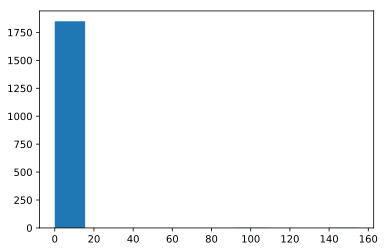

In [11]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline 
import matplotlib.pyplot as plt

### Test for Outliers
test_hist = df.loc[df["ID"] == "R260 R205 01-05-01"]["Traffic"]

plt.hist(test_hist)
plt.show()

###